<a href="https://colab.research.google.com/github/qubilab/CNN-for-skin-lesion-classification/blob/main/Case_1_Convolutional_Neural_Network_for_skin_lesion_classification_understanding_the_fundamentals_through_hands_on_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case 1: Example of classification of images of skin lesions as bening or malignant



## 0. Imports
---
Execute this cell to load all the necessary libraries to run the code. 

In [2]:
!pip install q keras==2.2.4
%tensorflow_version 1.15.0
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import  Model
from keras.optimizers import SGD
!pip install keras_lr_multiplier
from keras_lr_multiplier import LRMultiplier #this package needs to be installed
from keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from math import ceil
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot
from keras import models
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ISIC Dataset download
import csv
import urllib
import os
import pickle

# Split datasets
import random
random.seed(54)
import shutil
import pandas as pd

# Tensorflow
import tensorflow as tf

# Images
import matplotlib.image as mpimg
from skimage.exposure import rescale_intensity
import argparse
import cv2

! pip install -U scikit-image

#@title ISIC Api
import requests

class ISICApi(object):
    def __init__(self, hostname='https://isic-archive.com',
                 username=None, password=None):
        self.baseUrl = f'{hostname}/api/v1'
        self.authToken = None

        if username is not None:
            if password is None:
                password = input(f'Password for user "{username}":')
            self.authToken = self._login(username, password)

    def _makeUrl(self, endpoint):
        return f'{self.baseUrl}/{endpoint}'

    def _login(self, username, password):
        authResponse = requests.get(
            self._makeUrl('user/authentication'),
            auth=(username, password)
        )
        if not authResponse.ok:
            raise Exception(f'Login error: {authResponse.json()["message"]}')

        authToken = authResponse.json()['authToken']['token']
        return authToken

    def get(self, endpoint):
        url = self._makeUrl(endpoint)
        headers = {'Girder-Token': self.authToken} if self.authToken else None
        return requests.get(url, headers=headers)

    def getJson(self, endpoint):
        return self.get(endpoint).json()

    def getJsonList(self, endpoint):
        endpoint += '&' if '?' in endpoint else '?'
        LIMIT = 50
        offset = 0
        while True:
            resp = self.get(
                f'{endpoint}limit={LIMIT:d}&offset={offset:d}'
            ).json()
            if not resp:
                break
            for elem in resp:
                yield elem
            offset += LIMIT

     |████████████████████████████████| 317kB 8.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


  Created wheel for keras-lr-multiplier: filename=keras_lr_multiplier-0.8.0-cp36-none-any.whl size=5717 sha256=00b1fcc3b9e14df72e275cc577318c40313404b32456d615b142c724602c93de
  Stored in directory: /root/.cache/pip/wheels/2a/a5/a4/340d5432bced221b2bcca324e3257239784dd1220ab7c786e9
Successfully built keras-lr-multiplier
     |████████████████████████████████| 12.4MB 258kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


## 1. Loading and organizing the dataset
---
We will use the image dataset from the [ISIC Archive](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main), a public repository of images for the teaching, the development, and the testing of automated diagnostic systems.

To run the example, it is necessary to obtain the images and upload them on your Colab account "Files". For this, you first need to create a (free) account on the ISIC archive. Once you get your registration, insert your username and password into the cell below. Also, select the number of images per class that you want to upload.

The images will be temporarily saved in a new directory named "ISIC_2019" and organized in subfolders for the training/ validation/ test according to their classes. 

For the intuitive understanding of the steps of this example, it is sufficient to use a small number of images (~50-100 per class) that guarantee fast computation. However, for the training and fine-tuning of the CNN, larger dataset must be used with a corresponding slow down of the computation.

In [3]:
#@title 1.1 Access the dataset  { form-width: "30%" }
ISIC_username = "username" #@param{type: 'string'}
ISIC_password = "password" #@param{type: 'string'}
image_num =    50#@param{type: 'integer'}


In [4]:
#@title 1.2 Get metadata and create folders  { form-width: "30%" }

#@markdown Delete old folders (if exist) { form-width: "10%" }
!rm -rf "ISIC_2019"
!rm -rf "Toy_img"
!rm -rf "models_and_metadata_isic_images"

#@markdown Get image list and clone GitHub folder with metadata and trained CNNs { form-width: "10%" }

api = ISICApi(username=ISIC_username, password=ISIC_password)

Json_name = "image?limit=1000000&offset=0&sort=name"

imageList = api.getJson(Json_name)

if os.path.exists(os.path.join(os.getcwd(), 'metadata_isic_images', 'imagedata.csv'))==False:
  #! git clone https://github.com/SergioNoe/sergio_isic_images metadata_isic_images
  ! git clone https://github.com/qubilab/CNN-for-skin-lesion-classification models_and_metadata_isic_images

#@markdown Create a new folder named ISIC_2019 containing training, validation and test subfolders { form-width: "10%" }
newdir="ISIC_2019"
!mkdir $newdir

newdir="ISIC_2019/training"
!mkdir $newdir

newdir="ISIC_2019/training/benign"
!mkdir $newdir

newdir="ISIC_2019/training/malignant"
!mkdir $newdir

newdir="ISIC_2019/validation"
!mkdir $newdir

newdir="ISIC_2019/validation/benign"
!mkdir $newdir

newdir="ISIC_2019/validation/malignant"
!mkdir $newdir

newdir="ISIC_2019/test"
!mkdir $newdir

newdir="ISIC_2019/test/benign"
!mkdir $newdir

newdir="ISIC_2019/test/malignant"
!mkdir $newdir

newdir="Toy_img"
!mkdir $newdir

newdir="Toy_img/Toy"
!mkdir $newdir

newdir="Toy_img/Toy_RGB"
!mkdir $newdir

Cloning into 'models_and_metadata_isic_images'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 167 (delta 1), reused 6 (delta 1), pack-reused 160
Receiving objects: 100% (167/167), 453.07 MiB | 40.38 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (16/16), done.


In [5]:
#@title 1.3 Download the images and distribute them among the datasets  { form-width: "30%" }
#@markdown 1. Set percentage of images to be used for Training (default = 65%)
training  =  65  #@param{type: 'integer'} 
#@markdown 2. Set percentage of images to be used for Validation (default = 20%)
validation = 20 #@param{type: 'integer'}
#@markdown 3. Set percentage of images to be used for Test (default = 15%)
test = 15  #@param{type: 'integer'}

csvf = pd.read_csv("/content/models_and_metadata_isic_images/metadata/imagedata.csv")

csvf_BE = csvf[csvf["benign_malignant"] == "benign"]
csvf_MAL = csvf[csvf["benign_malignant"] == "malignant"]

probtrain =  training/100
probvalidation = validation/100

def download_image_dataset(subset, lesion, images, image_to_download):
  
  print("Downloading images of the class labeled as " + lesion + ".")

  savePath = "ISIC_2019/"
  savePathTrain = os.path.join(savePath, "training", lesion)
  savePathValidation = os.path.join(savePath, "validation", lesion)
  savePathTest = os.path.join(savePath, "test", lesion)
 
  indexes1 = list(range(0,images))
  index = random.sample(indexes1, min([images,image_to_download]))

  print("Found " + str(min([images,image_to_download])) + " of the " +str(image_to_download) + " required images.")


  k=0
  for index_1 in index:
    key = subset["isic_id"].keys()[index_1]
    name_img = subset["isic_id"][key]
    img_id = imageList[key]["_id"]
    imageFileResp = api.get('image/%s/download' % img_id)
    imageFileResp.raise_for_status()

    if k <= ceil(len(index)*probtrain):
      imageFileOutputPath = os.path.join(savePathTrain, '%s.jpg' % name_img)
    elif k > ceil(len(index)*probtrain) and k <= ceil((len(index)*probvalidation)+(len(index)*probtrain)):
      imageFileOutputPath = os.path.join(savePathValidation, '%s.jpg' % name_img)
    else:
      imageFileOutputPath = os.path.join(savePathTest, '%s.jpg' % name_img)

    with open(imageFileOutputPath, 'wb') as imageFileOutputStream:
      for chunk in imageFileResp:
        imageFileOutputStream.write(chunk)
    k+=1

#num_images = len(csvf_BE)
#if len(csvf_MAL)<num_images: num_images=len(csvf_MAL)
#download_image_dataset(csvf_BE, "benign", num_images, image_num)
#download_image_dataset(csvf_MAL, "malignant", num_images, image_num)

download_image_dataset(csvf_BE, "benign", len(csvf_BE), image_num)
download_image_dataset(csvf_MAL, "malignant", len(csvf_MAL), image_num)

#print("Downloading toy image.")
#savePathToy = "Toy_img/Toy"
#img_id = '5436e3abbae478396759f0cf'
#imageFileResp = api.get('image/%s/download' % img_id)
#imageFileResp.raise_for_status()
#imageFileOutputPath = os.path.join(savePathToy, '%s.jpg' % "ISIC_0000000")
#with open(imageFileOutputPath, 'wb') as imageFileOutputStream:
#  for chunk in imageFileResp:
#    imageFileOutputStream.write(chunk)

print("Done!")

# Defining paths to training, validation and test datasets { form-width: "10%" }
# change the destination path accordingly
#mainpath = '../ISIC_2019'
mainpath = "/content/ISIC_2019"
# in this example, we assume that the training, validation and test datsets have been already split in different folders
train_fold = os.path.join(mainpath, 'training')
validation_fold = os.path.join(mainpath, 'validation')
test_fold = os.path.join(mainpath, 'test')

# Define the input size of the network.
# We will use ResNet-50 that accepts inputs 224x224x3
inputSize= [224, 224, 3]

Found 50 of the 50 required images.
Found 50 of the 50 required images.
Done!


## 2. Understanding images and convolution
---
Visualize images and apply convolution kernels

In [ ]:
#@title 2.1 Select and visualize a random image
#@markdown 1. Choose a the dataset:
dataset = "test" #@param ["training", "validation", "test"]
#@markdown 2. Choose a class:
class_label = "benign" #@param ["benign", "malignant"]

inputSize=[224,224,3]
filenames=os.listdir(os.path.join('ISIC_2019',dataset,class_label)) 
rand_ind=np.random.randint(len(filenames))

fig_0 = pyplot.figure(1, figsize=(5, 5))
chart_1 = fig_0.add_subplot()
chart_1.title.set_text('Sample Image')

img = Image.open(os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind]))
img=img.resize(inputSize[0:2])
chart_1.imshow(img)
data = img.getdata()

In [ ]:
#@title 2.2 Images, layers and pixels

#@markdown An RGB image consists of three layers of pixels, where layers represents the red, green and blue component, respectively.

# #@markdown In the following, we will use ResNet-50, a neural network with 50 layers that allows to classify images according to different classes associated to the image content. In our example, we will use it to classify skin lesions.

# #@markdown ResNet-50 requires images with 224-by-224 pixels in RGB color coding.


# Image PIL y matrix

#fig_0 = pyplot.figure(1, figsize=(5, 5))
#chart_1 = fig_0.add_subplot()
#chart_1.title.set_text('Original Image')

#img = Image.open("Toy_img/Toy/ISIC_0000000.jpg")
#img=img.resize(inputSize[0:2])
#chart_1.imshow(img)
#data = img.getdata()

img = Image.open(os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind]))
img=img.resize(inputSize[0:2])

fig_1 = pyplot.figure(2, figsize=(16, 5))

chart_2 = fig_1.add_subplot(131)
chart_3 = fig_1.add_subplot(132)
chart_4 = fig_1.add_subplot(133)


chart_2.title.set_text('Red Channel')
chart_3.title.set_text('Green Channel')
chart_4.title.set_text('Blue Channel')

#@markdown Each pixels contains the numeric information about the intensity of each specific color.

# Suppress specific channels (e.g. (255, 120, 65) -> (0, 120, 0) for g)
r = [(d[0], 0, 0) for d in data]
g = [(0, d[1], 0) for d in data]
b = [(0, 0, d[2]) for d in data]

img.putdata(r)
img.save('Toy_img/Toy_RGB/r.png')
imgr = Image.open('Toy_img/Toy_RGB/r.png')
chart_2.imshow(imgr)

img.putdata(g)
img.save('Toy_img/Toy_RGB/g.png')
imgg = Image.open('Toy_img/Toy_RGB/g.png')
chart_3.imshow(imgg)

img.putdata(b)
img.save('Toy_img/Toy_RGB/b.png')
imgb = Image.open('Toy_img/Toy_RGB/b.png')
chart_4.imshow(imgb)

pyplot.show()

#img = Image.open("Toy_img/Toy/ISIC_0000000.jpg")
#img=img.resize(inputSize[0:2])
#img = np.array(img)

img = Image.open(os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind]))
img=img.resize(inputSize[0:2])
img = np.array(img)

# matrix plot
fig, (ax1, ax2, ax3) = pyplot.subplots(1,3)
fig.set_size_inches(16, 5)

min_val_i, min_val_j = 24, 84
size=10
intersection_matrix = img[:,:,0]

ax1.imshow(imgr) #
ax1.set_xlim([min_val_i,min_val_i+size])
ax1.set_ylim([min_val_j,min_val_j+size])


for i in range(min_val_i+1,min_val_i+size):
    for j in range(min_val_j+1,min_val_j+size):
        c = intersection_matrix[j,i]
        ax1.text(i, j, str(c), va='center', ha='center', color='w')

ax1.title.set_text('Zoom-in of a region of the red channel \n with pixel values')


intersection_matrix = img[:,:,1]

ax2.imshow(imgg) #
ax2.set_xlim([min_val_i,min_val_i+size])
ax2.set_ylim([min_val_j,min_val_j+size])

for i in range(min_val_i+1,min_val_i+size):
    for j in range(min_val_j+1,min_val_j+size):
        c = intersection_matrix[j,i]
        ax2.text(i, j, str(c), va='center', ha='center', color='w')

ax2.title.set_text('Zoom-in of a region of the green channel \n with pixel values')

intersection_matrix = img[:,:,2]

ax3.imshow(imgb) #
ax3.set_xlim([min_val_i,min_val_i+size])
ax3.set_ylim([min_val_j,min_val_j+size])

for i in range(min_val_i+1,min_val_i+size):
    for j in range(min_val_j+1,min_val_j+size):
        c = intersection_matrix[j,i]
        ax3.text(i, j, str(c), va='center', ha='center', color='w')

ax3.title.set_text('Zoom-in of a region of the blue channel \n with pixel values')

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

In [ ]:
#@title 2.3 Convolution kernels

#@markdown Example of convolution kernels

smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7 ))
largeBlur = np.ones((15, 15), dtype="float") * (1.0 / (15 * 15 ))
sharpen = np.array(([0, -1, 0],[-1, 5, -1],[0, -1, 0]), dtype="int")
laplacian = np.array(([0, 1, 0],[1, -4, 1],[0, 1, 0]), dtype="int")
sobelX = np.array(([-1, 0, 1],[-2, 0, 2],[-1, 0, 1]), dtype="int")
sobelY = np.array(([-1, -2, -1],[0, 0, 0],[1, 2, 1]), dtype="int")

fig_2,((ax1, ax2, ax3), (ax4, ax5, ax6)) = pyplot.subplots(2,3)
fig_2.set_size_inches(16, 12)
fig_2.suptitle("Convolution kernels", fontsize=16, y=0.92, weight='bold')

ax1.title.set_text("Small average kernel")
ax2.title.set_text("Large average kernel")
ax3.title.set_text("Sharpen kernel")
ax4.title.set_text("Laplacian kernel")
ax5.title.set_text("SobelX kernel")
ax6.title.set_text("SobelY kernel")

smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
ax1.imshow(smallBlur, cmap='gray')
for i in range(smallBlur.shape[1]):
    for j in range(smallBlur.shape[0]):
        c = np.round(smallBlur[j,i],2)
        ax1.text(i, j, str(c), va='center', ha='center', color="r")

largeBlur = np.ones((15, 15), dtype="float") * (1.0 / (15 * 15))
ax2.imshow(largeBlur, cmap='gray')
for i in range(largeBlur.shape[1]):
    for j in range(largeBlur.shape[0]):
        c = np.round(largeBlur[j,i],3)
        ax2.text(i, j, str(c), va='center', ha='center', color="r", fontsize=6)

ax3.imshow(sharpen, cmap='gray')
for i in range(sharpen.shape[1]):
    for j in range(sharpen.shape[0]):
        c = sharpen[j,i]
        ax3.text(i, j, str(c), va='center', ha='center', color='r')

ax4.imshow(laplacian, cmap='gray')
for i in range(laplacian.shape[1]):
    for j in range(laplacian.shape[0]):
        c = laplacian[j,i]
        ax4.text(i, j, str(c), va='center', ha='center', color='r')

ax5.imshow(sobelX, cmap='gray')
for i in range(sobelX.shape[1]):
    for j in range(sobelX.shape[0]):
        c = sobelX[j,i]
        ax5.text(i, j, str(c), va='center', ha='center', color='r')

ax6.imshow(sobelY, cmap='gray')
for i in range(sobelY.shape[1]):
    for j in range(sobelY.shape[0]):
        c = sobelY[j,i]
        ax6.text(i, j, str(c), va='center', ha='center', color='r')




In [ ]:
#@title 2.4 Results of convolution

def convolve(image0, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
	(iH, iW) = image0.shape[:2]
	(kH, kW) = kernel.shape[:2]
	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
	pad = (kW - 1) // 2
	
	output3 = np.zeros((iH, iW,3), dtype="float32")
	# loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to
	# bottom
	for z in range(3):
		output = np.zeros((iH, iW), dtype="float32")
		image = cv2.copyMakeBorder(image0[:,:,z], pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
		#image=image0[:,:,z]
		for y in np.arange(pad, iH + pad):
			for x in np.arange(pad, iW + pad):
				# extract the ROI of the image by extracting the
				# *center* region of the current (x, y)-coordinates
				# dimensions
				roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
				# perform the actual convolution by taking the
				# element-wise multiplicate between the ROI and
				# the kernel, then summing the matrix
				k = (roi * kernel).sum()
				# store the convolved value in the output (x,y)-
				# coordinate of the output image
				output[y - pad, x - pad] = k

	# rescale the output image to be in the range [0, 255]
		#output3[:,:,z] = rescale_intensity(output, in_range=(0, 255))
		output3[:,:,z] = np.round(output,0)
	output3 = (output3).astype("uint8")
	# return the output image
	return output3

#@markdown Effect of image convolution using different kernels

#fig_0 = pyplot.figure(1, figsize=(20, 5))
#chart_1 = fig_0.add_subplot()
#chart_1.title.set_text("Original Image")
img = Image.open(os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind]))
img=img.resize(inputSize[0:2])
#chart_1.imshow(img)
img = np.array(img)

small_kernel = convolve(img, smallBlur)
large_kernel = convolve(img, largeBlur)
sharpen_kernel = convolve(img, sharpen)
laplacian_kernel = convolve(img, laplacian)
sobelX_kernel = convolve(img, sobelX)
sobelY_kernel = convolve(img, sobelY)


fig_1,((bx1, bx2, bx3), (bx4, bx5, bx6)) = pyplot.subplots(2,3)
fig_1.set_size_inches(16, 12)
fig_1.suptitle("Image convolution", fontsize=16, y=0.92, weight='bold')

bx1.imshow(small_kernel)
bx2.imshow(large_kernel)
bx3.imshow(sharpen_kernel)
bx4.imshow(laplacian_kernel)
bx5.imshow(sobelX_kernel)
bx6.imshow(sobelY_kernel)

bx1.title.set_text("Small average kernel")
bx2.title.set_text("Large average kernel")
bx3.title.set_text("Sharpen kernel")
bx4.title.set_text("Laplacian kernel")
bx5.title.set_text("SobelX kernel")
bx6.title.set_text("SobelY kernel")


## 3. Data augmentation
---
By applying transformations, such as reflection along the x or y axis, translations, and rotations, to the images in the original dataset we can improves generalization.



In [ ]:
#@title 3.1 Define transformations and apply them to the training set{ form-width: "30%" }

# Create image generator with for the training dataset
# Use data augmentation to prevent the memorization of image features
# Here we apply reflection (both x and y axis), translation (between -30 and 30 pixels,
# and rotation (up to 45 degrees).

datagenTrain = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=False,
        samplewise_std_normalization=False,
        rotation_range= 45,
        width_shift_range=[-30, 30],
        height_shift_range=[-30, 30],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

# create image generator without augmentation for the validation and test dataset
datagenValTest = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=False,
        samplewise_std_normalization=False)

## Create datasets, keeping the same organization in subfolders. The folder name correspond to the class label

Train_set = datagenTrain.flow_from_directory(train_fold, batch_size=32 ,target_size = inputSize[0:2], class_mode="categorical")
Validation_set = datagenValTest.flow_from_directory(validation_fold, batch_size=32 ,target_size = inputSize[0:2], class_mode="categorical")
Test_set = datagenValTest.flow_from_directory(test_fold, target_size = inputSize[0:2])




In [ ]:
#@title 3.2 Select the number of augmented images to show { form-width: "30%" }

##@title Original image { form-width: "30%" }
#img = Image.open(os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind]))
#img=img.resize(inputSize[0:2])
#pyplot.imshow(img)
#pyplot.show()
!rm -rf "Toy_img"

newdir="Toy_img"
!mkdir $newdir

newdir="Toy_img/Toy"
!mkdir $newdir

original=os.path.join('ISIC_2019',dataset,class_label,filenames[rand_ind])
target=os.path.join('Toy_img','Toy',filenames[rand_ind])
shutil.copyfile(original, target)

Toy_set = datagenTrain.flow_from_directory("/content/Toy_img/", batch_size=32 ,target_size = inputSize[0:2])

img_generated =  24#@param{type: 'integer'}

#@markdown We show an example of the augmentation result, using the random image selected above, being transformed accordingly.

# Observe result of an image after execute the augmentation


sub_plots = list(range(1,img_generated+1))
fig = pyplot.figure(figsize=(50, 50))

for img in range(0,img_generated):
  x,y = Toy_set.next()
  image = x[0]
  sub = fig.add_subplot(8,8, sub_plots[img]) #change for optimal display based on number of images
  sub.imshow(image)
pyplot.show()


## 4. The CNN: ResNet-50 (*Optional*)
---
*If you don't want to train the network, skip this section and go to:* **7. Load a trained network**

Download the pre-trained ResNet-50 architecture.

In [ ]:
#@title 4.1 Pre-processing and augmentation
#@markdown Define data-preprocessing and augmentation for fine-tuning
#
#@markdown Set the batch size, the number of images used to optimize the network at each iteration
batch_size= 6 #@param {type:"integer"}
datagenTrain = ImageDataGenerator(preprocessing_function=preprocess_input,
        rotation_range= 90,
        width_shift_range=[-30, 30],
        height_shift_range=[-30, 30],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagenValTest = ImageDataGenerator(preprocessing_function=preprocess_input)
#
Train_set =   datagenTrain.flow_from_directory(train_fold,
                                batch_size=batch_size,
                                target_size = inputSize[0:2],
                                class_mode="categorical")
Validation_set = datagenValTest.flow_from_directory(validation_fold,
                                batch_size=batch_size,
                                target_size = inputSize[0:2],
                                class_mode="categorical")

Test_set = datagenValTest.flow_from_directory(test_fold,
                                target_size = inputSize[0:2],
                                class_mode="categorical")

from collections import Counter
counter = Counter(Train_set.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}


In [ ]:
#@title 4.2 Load the pre-trained ResNet-50 and change the final layers

#@markdown  Download the pre-trained ResNet-50 with weights obtained from training on the [Imagenet](http://image-net.org/index) dataset
#load the pre-trained Network, weights obtained from training on ImageNet dataset
#@markdown To classify lesions as benign/malignant, we need to substitute the final layers (fc1000) of the ResNet-50 to reduce the number of ouputs from 1000 to 2.
# The new fully connected layer will have a number of classes equal to Train_data.num_classes (2)

model_ResNet50 = ResNet50(include_top=False,pooling = 'avg', weights='imagenet', input_shape=(224,224,3))
x = model_ResNet50.output
fc2 = Dense(Train_set.num_classes, activation='softmax', name = 'fc2')(x)
model = Model(inputs=model_ResNet50.input, outputs=fc2)


In [ ]:
#@title 4.3 Visualize the final architecture
#@markdown Notice the change of number of classes of the last dense layer.
# this is the final architecture
#model = Model(inputs=model_ResNet50.input, outputs=predict)
print(model.summary())


## 5. Hyperparameters (*Optional*)
---
*If you don't want to train the network, skip this section and go to:* **7. Load a trained network**

In [ ]:
#@title 5.1 Learning rate { form-width: "30%" }
#@markdown Define the base learning rate and the momentum of the optimizer of the network. 
learning_rate = 0.0001 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
#@markdown One can also change the learning rate of some layer, for example the prediction layer, with respect to the base 
#@markdown learning rate, by multiplying it for a factor: 
m_factor = 10 #@param {type:"integer"}
# Before starting the training, there are a few hyperparameters to set
# First, we define the base learning rate lr and the momentum
# Here we can also change the learning rate of some layer, for example the fully connected layer
# with respect to the base learning rate (1 means the same as the base one, 10 means 10x faster)
opt =LRMultiplier(SGD(lr=learning_rate, momentum=momentum, nesterov=False), {'fc2': m_factor} ) #

In [ ]:
#@title 5.2 Variable learning rate and stopping condition { form-width: "30%" }
def lr_scheduler(epoch, lr): 
  #@markdown  Reduce the learning rate by a factor 
  factor =  0.1 #@param {type:"number"}
  #@markdown every
  step = 5 #@param {type:"integer"}
  #@markdown where each step corresponds to an epoch of training. { form-width: "10%" }
  if epoch % step == 0 and epoch:
      return lr * factor
  return lr

#@markdown Stop the training if the loss function doesn't decrease for 
patience =  10#@param {type:"integer"} 
#@markdown epochs. { form-width: "10%" }

# we will change the learning rate piecewise every 5 epochs by reducing it  by a factor 10
#def lr_scheduler(epoch, lr): #reduce learning rate 0.1 after 5 epochs
#    factor = factor
#    step = step
#   if epoch % step == 0 and epoch:
#        return lr * factor
#    return lr
Learning_rate_decrease = LearningRateScheduler(lr_scheduler, verbose=1)

# stop the optimization if the loss function doesn't decrease for # iter
stopping = EarlyStopping(monitor='val_loss', patience=patience)


In [ ]:
#@title 5.3 (optional) Freezing layers

#@markdown We can choose if a layer of ResNet-50 will be trained or not using the code line from below. In this example, we choose to "freeze", or maintain the weights obtained on the Imagenet dataset.

for layer in range(0,20):
  model.layers[layer].trainable = False

In [ ]:
#@title 5.4 Loss function and metrics { form-width: "30%" }
#@markdown Select the **categorical crossentropy** as the loss function and the **accuracy** as the metrics. { form-width: "10%" }

# define loss function and metrics
model.compile(optimizer=opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
#@title 5.5 Model saving and performance visualization { form-width: "30%" }
#@markdown Check the loss function value at the end of each iteration, save the model when performance improves. 

#Save best model
with open("./model_architecture.json", 'w') as f:
        f.write(model.to_json())
checkpointer = ModelCheckpoint("./model_weights.h5", verbose=0,monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)


#@markdown At every iteration/epoch, show losses and accuracy for training and validation datasets.

class GraphCallback(Callback):
  def set_model(self, model):
    self.model = model
    layer_outputs = [layer.output for layer in model.layers]
    self.activations_model = Model(model.input, layer_outputs)

  list_batch_acc = []
  list_batch_loss = []
  list_epoch_val_acc = []
  list_epoch_val_loss = []

  def on_train_batch_end(self, batch, logs=None):
    GraphCallback.list_batch_acc.append(logs["accuracy"])
    GraphCallback.list_batch_loss.append(logs["loss"])

  def on_epoch_end(self, epoch, logs=None):

    GraphCallback.list_epoch_val_acc.append(logs["val_accuracy"])
    GraphCallback.list_epoch_val_loss.append(logs["val_loss"])
    
    if epoch > 1:

      fig_1, axs_1 = pyplot.subplots(1, 2, figsize=(20, 5))

      epochs_batch = ceil(Train_set.n / batch_size)
      list_epoch = []
      for i in range(0,len(GraphCallback.list_epoch_val_acc)):
        list_epoch.append((i+1)*epochs_batch)
      
      list_ticks = []
      for i in range(0,len(list_epoch)):
        list_ticks.append(str(i+1))
      
      axs_1[0].plot(GraphCallback.list_batch_acc)
      axs_1[0].plot(list_epoch,GraphCallback.list_epoch_val_acc)
      axs_1[0].set_xticks(list_epoch)
      axs_1[0].set_xticklabels(list_ticks)
      axs_1[0].set_title("Model Accuracy")
      axs_1[0].set_xlabel("Epoch")
      axs_1[0].set_ylabel("Accuracy")
      axs_1[0].legend(["Train","Validation"])

      axs_1[1].plot(GraphCallback.list_batch_loss)
      axs_1[1].plot(list_epoch,GraphCallback.list_epoch_val_loss)
      axs_1[1].set_xticks(list_epoch)
      axs_1[1].set_xticklabels(list_ticks)
      axs_1[1].set_title("Model Loss")
      axs_1[1].set_xlabel("Epoch")
      axs_1[1].set_ylabel("Loss")
      axs_1[1].legend(["Train","Validation"])
    
      pyplot.show()

graphcallback = GraphCallback()



## 6. Fine-tuning the model (*Optional*)
---
*If you don't want to train the network, skip this section and go to:* **7. Load a trained network**

Start the training of our model with a maximum of 50 epochs and validating the trained net in every epoch with the validation dataset.

In [ ]:
# @title 6.1 Start the fine-tuning
model_history = model.fit_generator(Train_set, steps_per_epoch = ceil(Train_set.n / batch_size) ,epochs=150, shuffle=True,
                                    validation_data=Validation_set, validation_steps = ceil(Validation_set.n / batch_size),
                                    callbacks=[stopping, Learning_rate_decrease, checkpointer, graphcallback], verbose=2,
                                    class_weight=class_weights)

In [ ]:
# @title 6.2 Visualize Final Loss and Accuracy
# Loss plot
pyplot.plot(model_history.history["loss"])
pyplot.plot(model_history.history["val_loss"])
pyplot.title("Model loss")
pyplot.ylabel("Loss")
pyplot.xlabel("Epoch")
pyplot.legend(["Training","Validation"], loc="upper left")
pyplot.show()

# ACC plot
pyplot.plot(model_history.history["accuracy"])
pyplot.plot(model_history.history["val_accuracy"])
pyplot.title("Model accuracy")
pyplot.ylabel("Accuracy")
pyplot.xlabel("Epoch")
pyplot.legend(["Training","Validation"], loc="upper left")
pyplot.show()

## 7. Load a trained network
---
*Skip this activity if you have fine-tuned your network. Go to:* **8. Performance assessment** 


In [6]:
#@title 7.1 Load the pre-trained network
#@markdown Load a ResNet-50 CNN fine-tuned on the ISIC 2019 dataset.
with open("/content/models_and_metadata_isic_images/trained_CNN_case1/model_architecture.json", 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
#model_j.summary()

#
model.load_weights("/content/models_and_metadata_isic_images/trained_CNN_case1/model_weights.h5")
model.compile(optimizer='SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#@title 7.2 Visualize the CNN architecture
model.summary()

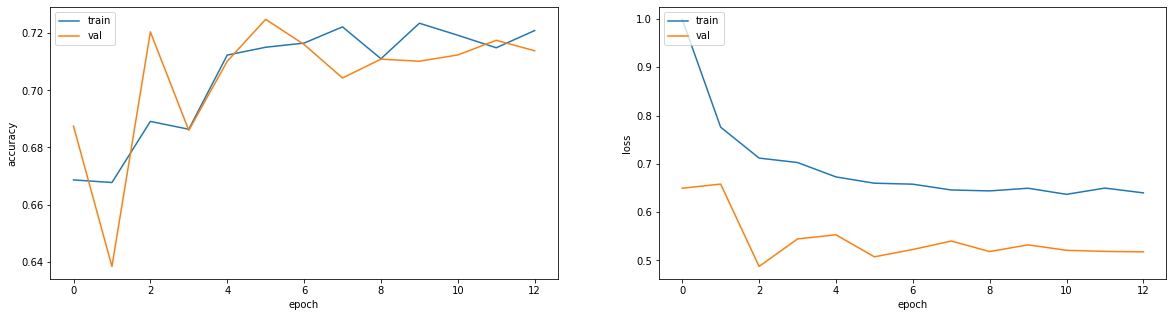

In [7]:
#@title 7.3 Show performance curves { form-width: "30%" }
#@markdown Display the evolution of accuracy and losses for the training and validation dataset.
with open('/content/models_and_metadata_isic_images/trained_CNN_case1/trainHistoryDict', 'rb') as file_pi:
      history=pickle.load(file_pi)

fig_1, axs_1 = pyplot.subplots(1, 2, figsize=(20, 5))
axs_1[0].plot(history['acc'])
axs_1[0].plot(history['val_acc'])
axs_1[0].set_ylabel('accuracy')
axs_1[0].set_xlabel('epoch')
axs_1[0].legend(['train', 'val'], loc='upper left')

axs_1[1].plot(history['loss'])
axs_1[1].plot(history['val_loss'])
axs_1[1].set_ylabel('loss')
axs_1[1].set_xlabel('epoch')
axs_1[1].legend(['train', 'val'], loc='upper left')



In [99]:
#@title 7.4 Build a new test set { form-width: "30%" }
#@markdown Since we are using a model trained on the same dataset, we must ensure that the test images were not used for the training

!rm -rf "ISIC_2019"

newdir="ISIC_2019"
!mkdir $newdir

newdir="ISIC_2019/test"
!mkdir $newdir

newdir="ISIC_2019/test/benign"
!mkdir $newdir

newdir="ISIC_2019/test/malignant"
!mkdir $newdir

#@markdown Set the number of images for the new test set
test_img  =  40  #@param{type: 'integer'} 

#csvf_BE = csvf[csvf["benign_malignant"] == "benign"]
#csvf_MAL = csvf[csvf["benign_malignant"] == "malignant"]

def download_newtest_dataset(subset,lesion, test_img):
  with open ('/content/models_and_metadata_isic_images/metadata/'+lesion+'_test.txt', 'rb') as fp:
    list_1 = pickle.load(fp)
  savePath = "ISIC_2019/"
  savePathTest = os.path.join(savePath, "test", lesion)
  if len(list_1)>test_img:
    ind=random.sample(list(list_1), test_img)
  else: ind=list(list_1)
  print("Downloading images of the class labeled as " + lesion + ".")
  print("..........")
  for i in ind:
     key = subset["isic_id"].keys()[i]
     name_img = subset["isic_id"][key]
     img_id = imageList[key]["_id"]
     imageFileResp = api.get('image/%s/download' % img_id)
     imageFileResp.raise_for_status()
     imageFileOutputPath = os.path.join(savePathTest, '%s.jpg' % name_img)
     with open(imageFileOutputPath, 'wb') as imageFileOutputStream:
       for chunk in imageFileResp:
         imageFileOutputStream.write(chunk)

download_newtest_dataset(csvf_BE,'benign', test_img)
download_newtest_dataset(csvf_MAL, 'malignant', test_img)
print("Done.")


datagenValTest = ImageDataGenerator(preprocessing_function=preprocess_input)
#

Test_set = datagenValTest.flow_from_directory(test_fold,
                                target_size = inputSize[0:2],
                                class_mode="categorical", shuffle=False)



..........
..........
Done.
Found 80 images belonging to 2 classes.


## 8. Performance assessment

---



Use the test dataset, that contains different images with respect to those used for the training and validation, to evaluate the performance of the model.


In [100]:
#@title 8.1 Predictions { form-width: "30%" }
#@markdown Obtain a prediction (benign/malignant) for each image of the test datset
#Load Test_set images and labels
x_Test,y_Test =[],[]
for i in range(ceil(Test_set.n/Test_set.batch_size)):
  x_test,y_test = Test_set.next()
  x_Test.extend(x_test)
  y_Test.extend(y_test)
x_Test=np.array(x_Test)  
y_Test=np.array(y_Test) 
Predictions = model.predict(x_Test)
#One hot vector encoding for Test_set labels
One_Hot_vector = np.argmax(y_Test,1)



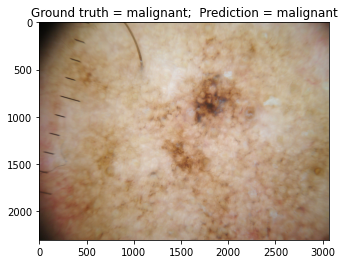

In [111]:
#@title 8.2 Show example of test images with ground-truth and corresponding prediction { form-width: "30%" }
k=np.random.randint(Test_set.n)
class_label=['benign','malignant']
fig_ = pyplot.figure(1)
chart_1 = fig_.add_subplot()

#img = x_Test[k]
img = Image.open(os.path.join('ISIC_2019','test',Test_set.filenames[k]))
chart_1.imshow(img)
chart_1.title.set_text('Ground truth = '+ class_label[int(One_Hot_vector[k])] + ';  Prediction = ' + class_label[np.argmax(Predictions[k])])



The accuracy calculated over the 80 images composing the test set is equal to 69.0%


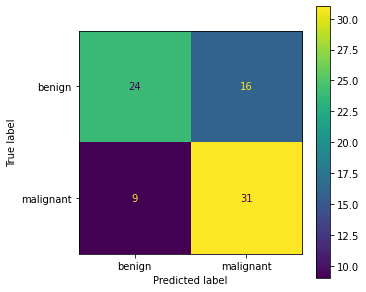

In [113]:
# @title 8.3 Accuracy and confusion matrix { form-width: "30%" }
# Calculate accuracy over the test dataset
#Test_set accuracy
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

#Test_acc = model.evaluate_generator(Test_set)[1]
Test_acc = accuracy_score(np.argmax(y_Test, axis = 1), np.argmax(Predictions, axis = 1))
print('The accuracy calculated over the ' + str(Test_set.n) + ' images composing the test set is equal to ' + str(np.round(Test_acc*100,0)) + '%' )

Conf_mat = confusion_matrix(np.argmax(y_Test, axis = 1), np.argmax(Predictions, axis = 1))
disp = ConfusionMatrixDisplay(Conf_mat,Test_set.class_indices.keys())
disp.plot()
disp.figure_.set_size_inches(5, 5)
pyplot.show()


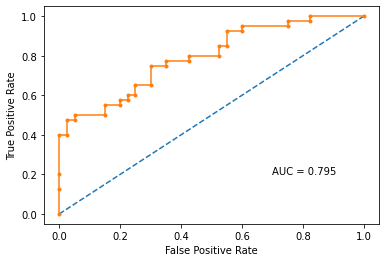

In [114]:
# @title 8.4 ROC curve and AUC

# @markdown Plot the ROC curve using the labels of the test dataset and the predictions made by the model and calculate the AUC.
#Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_Test[:,0], Predictions[:,0])
#Calculate and print AUC
AUC = auc(fpr, tpr)

pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.7,0.2,'AUC = ' +str(np.round(AUC,3)) )
pyplot.show()

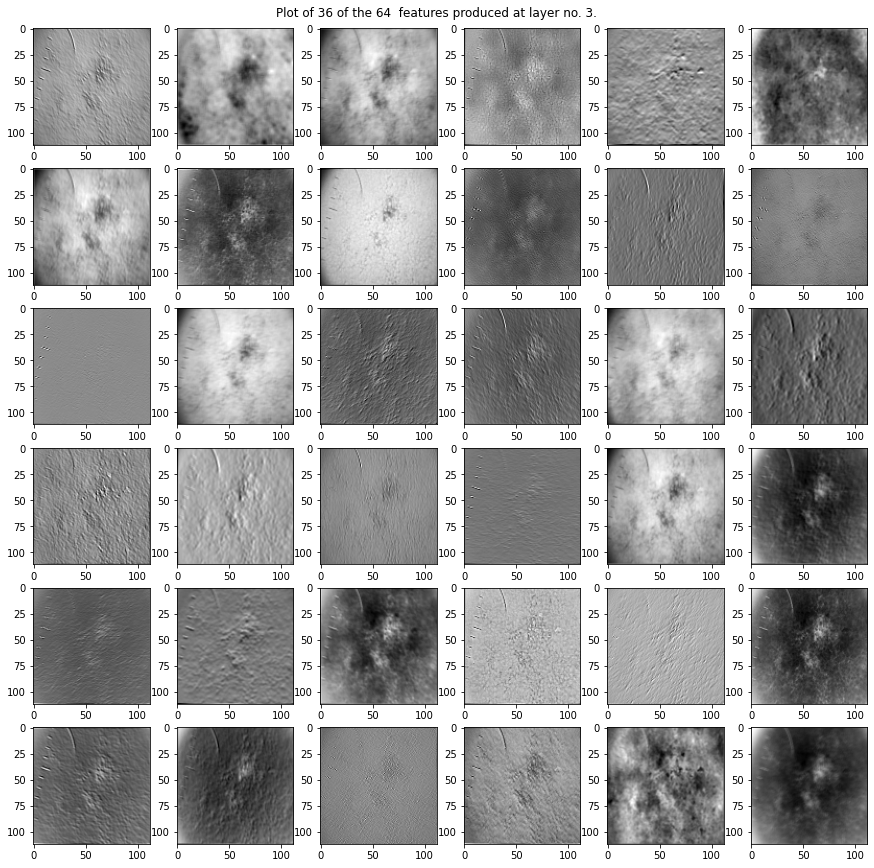

In [115]:
#@title 8.5 Visualize features generated at a specific layer  { form-width: "30%" }
im = x_Test[k] #choose an image
#@markdown Choose a layer between 0 and 174 { form-width: "10%" }
layer_number =  3#@param{type: 'integer'}

# Original image
#pyplot.imshow(im)

# Adding a dimension
im = np.expand_dims(im, axis=0)
layer_name = 'my_layer'
intermediate_layer_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer(index=layer_number).output)
Layer_pred = intermediate_layer_model.predict(im)

n_feat_to_show=np.min([Layer_pred.shape[-1], 36])

subplot_X = int( n_feat_to_show**(1/2) ) 
subplot_Y = int( n_feat_to_show**(1/2) )
fig = pyplot.figure(figsize=(15,15) )
fig.suptitle('Plot of %d of the %d  features produced at layer no. %d.'%(n_feat_to_show,Layer_pred.shape[-1],layer_number), y=0.9 )
for i in range(n_feat_to_show):#range(Layer_pred.shape[-1]):
  sub = fig.add_subplot(subplot_X,subplot_Y, i + 1) #change for optimal display based on number of images
  sub.imshow(Layer_pred[0,:,:,i], cmap='gray')
pyplot.show()
